In [ ]:
# Convert dataset to NILMTK format
from nilmtk.dataset_converters import convert_refit
convert_refit('/home/divansh/Desktop/Coursework/BTP/MultiApplianceAnomalyDetection/datasets/refit-cleaned/', '/home/divansh/Desktop/Coursework/BTP/MultiApplianceAnomalyDetection/datasets/refit.h5')

In [ ]:
from nilmtk import DataSet
from nilmtk.utils import print_dict
refit = DataSet('/home/divansh/Desktop/Coursework/BTP/MultiApplianceAnomalyDetection/datasets/refit.h5')
print_dict(refit.metadata)

In [57]:
elec= refit.buildings[1].elec
elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REFIT', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REFIT', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=3, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=2)])
  ElecMeter(instance=5, building=1, dataset='REFIT', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REFIT', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REFIT', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REFIT', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=9, building=1, dataset='REFIT', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=10, building=1, data

In [ ]:
computer = elec['computer']
computer.available_columns()

In [ ]:
df = next(computer.load())

In [ ]:
df[(df['power'].notna())]

In [62]:
fridge = elec[2]
fridge.available_columns()
df = next(fridge.load())

In [ ]:
df[df['power'].notna()]

In [ ]:
elec.proportion_of_energy_submetered()


In [69]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline


/home/divansh/anaconda3/envs/nilmtk-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [70]:
rcParams['figure.figsize'] = (13, 6)

In [94]:
train = DataSet('/home/divansh/Desktop/Coursework/BTP/MultiApplianceAnomalyDetection/datasets/refit.h5')
test = DataSet('/home/divansh/Desktop/Coursework/BTP/MultiApplianceAnomalyDetection/datasets/refit.h5')
building = 1
train.set_window(end="2014-10-01")
test.set_window(start="2014-10-01", end="2015-10-01")
    
train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec


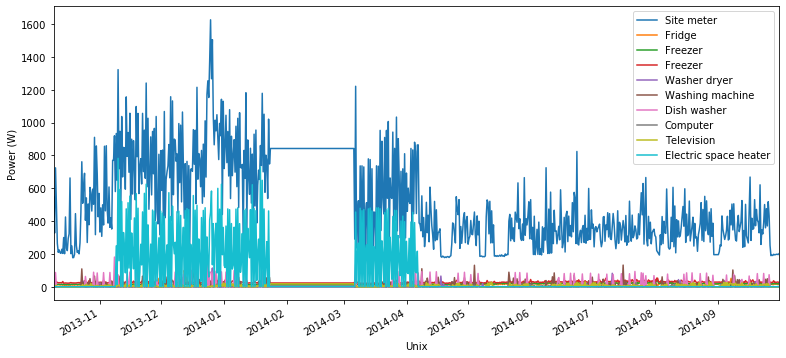

In [95]:
train_elec.plot()

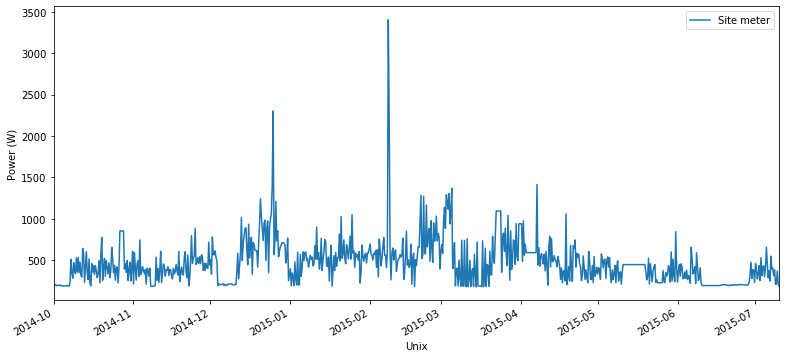

In [96]:
test_elec.mains().plot()

In [97]:
mains = train_elec.mains()

In [98]:
mains_df = next(mains.load())
mains_df.head()

physical_quantity,power
type,active
Unix,
2013-10-09 14:06:17+01:00,523
2013-10-09 14:06:31+01:00,526
2013-10-09 14:06:46+01:00,540
2013-10-09 14:07:01+01:00,532
2013-10-09 14:07:15+01:00,540


In [99]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

9/9 ElecMeter(instance=10, building=1, dataset='REFIT', appliances=[Appliance(type='electric space heater', instance=1)])

In [100]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=7, building=1, dataset='REFIT', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=2, building=1, dataset='REFIT', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=2)])
  ElecMeter(instance=3, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=10, building=1, dataset='REFIT', appliances=[Appliance(type='electric space heater', instance=1)])
)

In [101]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall


In [ ]:
import numpy.random
numpy.random.seed(42)


In [102]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])


********************
CO
********************
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='REFIT', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='REFIT', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=2)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=1, dataset='REFIT', appliances=[Appliance(type='electric space heater', instance=1)])'
Done training!
Runtime = 28.013263463974 seconds.
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REFIT', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='REFIT', appli

In [104]:
appliance_labels = [m.label() for m in gt.columns.values]

In [113]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels


In [114]:
gt.head()


,Dish washer,Fridge,Freezer,Freezer,Electric space heater
Unix,,,,,
2014-10-01 00:00:00+01:00,0.0,69.0,71.0,0.0,1.0
2014-10-01 00:00:30+01:00,0.0,70.0,72.0,0.0,1.0
2014-10-01 00:01:00+01:00,0.0,69.4,71.0,0.0,1.0
2014-10-01 00:01:30+01:00,0.0,69.0,70.8,0.0,1.0
2014-10-01 00:02:00+01:00,0.0,69.0,71.0,0.0,1.0


In [115]:
predictions['CO'].head()


,Dish washer,Fridge,Freezer,Freezer,Electric space heater
Unix,,,,,
2014-10-01 00:00:00+01:00,100.0,73.0,72.0,47.0,0.0
2014-10-01 00:00:30+01:00,100.0,73.0,72.0,47.0,0.0
2014-10-01 00:01:00+01:00,100.0,73.0,72.0,47.0,0.0
2014-10-01 00:01:30+01:00,100.0,73.0,72.0,47.0,0.0
2014-10-01 00:02:00+01:00,100.0,73.0,72.0,47.0,0.0


In [116]:
predictions['FHMM'].head()


,Dish washer,Fridge,Freezer,Freezer,Electric space heater
Unix,,,,,
2014-10-01 00:00:00+01:00,115.0,73.0,71.0,0.0,1.0
2014-10-01 00:00:30+01:00,115.0,73.0,80.0,0.0,1.0
2014-10-01 00:01:00+01:00,115.0,73.0,80.0,0.0,1.0
2014-10-01 00:01:30+01:00,115.0,73.0,80.0,0.0,1.0
2014-10-01 00:02:00+01:00,115.0,73.0,80.0,0.0,1.0


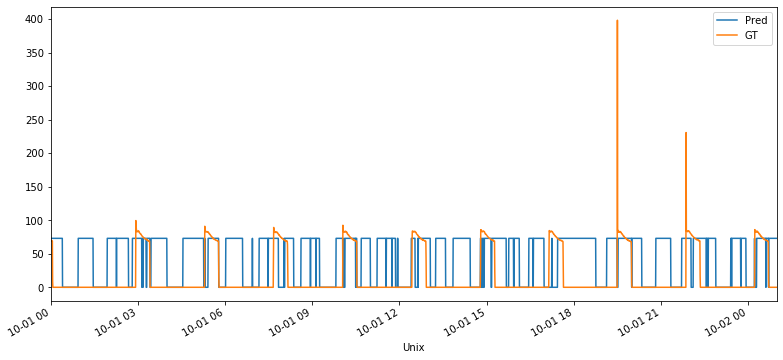

In [122]:
predictions['CO']['Fridge'].head(3000).plot(label="Pred")
gt['Fridge'].head(3000).plot(label="GT")
plt.legend()


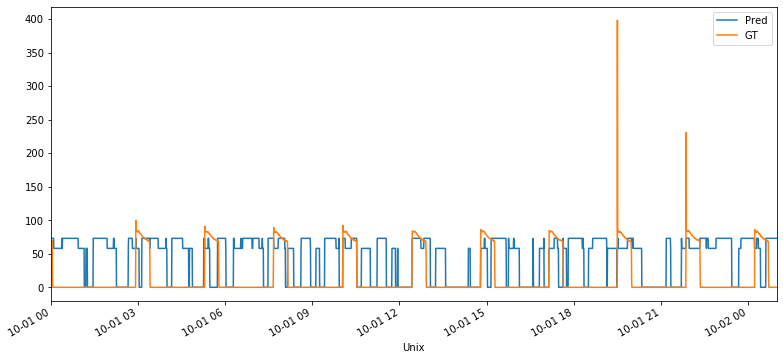

In [121]:
predictions['FHMM']['Fridge'].head(3000).plot(label="Pred")
gt['Fridge'].head(3000).plot(label="GT")
plt.legend()


In [119]:
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)


In [120]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse


,CO,FHMM
Dish washer,286.763058,475.015334
Fridge,304.730482,59.323731
Freezer,173.812269,37.650161
Electric space heater,309.173196,222.768457
